In [1]:
import sys
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.handlers import EarlyStopping

sys.path.insert(1, 'C:\\Users\\shrey\\Desktop\\NUS- Everything\\Semester 7\\CG4002\\CG4002_B18\\sw1_ml\\src\\data\\')
sys.path.insert(2, 'C:\\Users\\shrey\\Desktop\\NUS- Everything\\Semester 7\\CG4002\\CG4002_B18\\sw1_ml\\src\\model\\')
sys.path.insert(3, 'C:\\Users\\shrey\\Desktop\\NUS- Everything\\Semester 7\\CG4002\\CG4002_B18\\sw1_ml\\src\\feature_extraction\\')

from load_nn_data import load_neural_network_data
from load_data import load_dance_data, load_position_data, load_position_data_w11
from load_data import one_hot_encoder
from combine_data import combine_dance_data, pre_process_dance_data, combine_all_dancer_data, pre_process_position_data, combine_all_position_data
from neural_network_model import neural_network_model_fpga

Run below when new data is added

In [14]:
# dataset = 'C:\\Users\\shrey\\Desktop\\NUS- Everything\\Semester 7\\CG4002\\CG4002_B18\\DataSets\\dance13_test\\'
dataset = 'C:\\Users\\shrey\\Desktop\\NUS- Everything\\Semester 7\\CG4002\\CG4002_B18\\DataSets\\dance13_test1\\'
combine_dance_data(dataset)
pre_process_dance_data(dataset)

Files read from  shre_err_13


In [15]:
dataset = 'C:\\Users\\shrey\\Desktop\\NUS- Everything\\Semester 7\\CG4002\\CG4002_B18\\DataSets\\'
combine_all_dancer_data(dataset, 'dance13_test1', 'combined13_test')

In [13]:
dataset = 'C:\\Users\\shrey\\Desktop\\NUS- Everything\\Semester 7\\CG4002\\CG4002_B18\\DataSets\\combined13_test\\'
# dataset = 'C:\\Users\\shrey\\Desktop\\NUS- Everything\\Semester 7\\CG4002\\CG4002_B18\\DataSets\\combined13\\'

sampling_rate = 5
window_size = 2.56

X, y = load_dance_data(dataset, sampling_rate, window_size)

Files read from elbow.txt
Files read from hair.txt
Files read from logout.txt
Files read from pushback.txt
Files read from rocket.txt
Files read from scarecrow.txt
Files read from shoulder.txt
Files read from window.txt
Files read from zigzag.txt


### NEURAL NETWORK IMPLEMENTATION

Ignite is a High-level library to help with training neural networks in PyTorch. It comes with an Engine to setup a training loop, various metrics, handlers and a helpful contrib section!

Below we import the following:

* **Engine**: Runs a given process_function over each batch of a dataset, emitting events as it goes.
* **Events**: Allows users to attach functions to an Engine to fire functions at a specific event. Eg: EPOCH_COMPLETED, ITERATION_STARTED, etc.
* **Accuracy**: Metric to calculate accuracy over a dataset, for binary, multiclass, multilabel cases.
* **Loss**: General metric that takes a loss function as a parameter, calculate loss over a dataset.
* **RunningAverage**: General metric to attach to Engine during training.
* **EarlyStopping**: Handler to stop training based on a score function.

In [19]:
X, y = shuffle(X, y)
X_train, X_test = X[:int(len(X)*0.8), :], X[int(len(X)*0.8):, :]
y_train, y_test = y[:int(len(X)*0.8), :], y[int(len(X)*0.8):, :]

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
y_train = y_train.reshape(y_train.shape[0]).long()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
y_test = y_test.reshape(y_test.shape[0]).long()

in_size = X.shape[1]
out_size = one_hot_encoder(y).shape[1]

In [16]:
nn_model = neural_network_model_fpga(input_size=in_size, hidden_states= [256,128], output_size=out_size)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
trainloader, testloader = load_neural_network_data(X_train, y_train, X_test, y_test)

In [21]:
def score_function(engine):
    val_loss = engine.state.metrics['crossentropy']
    accuracy = engine.state.metrics['accuracy']
    return accuracy

trainer = create_supervised_trainer(nn_model, optimizer, loss)
evaluator = create_supervised_evaluator(nn_model,
                                        metrics={
                                            'accuracy': Accuracy(),
                                            'crossentropy': Loss(loss)
                                            })

handler = EarlyStopping(patience=5, score_function=score_function, trainer=trainer)
# Note: the handler is attached to an *Evaluator* (runs one epoch on validation dataset).
evaluator.add_event_handler(Events.COMPLETED, handler)

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(trainloader)
    metrics = evaluator.state.metrics
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, metrics['accuracy'], metrics['crossentropy']))

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(testloader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, metrics['accuracy'], metrics['crossentropy']))

trainer.run(trainloader, max_epochs=25)

Training Results - Epoch: 1  Avg accuracy: 0.92 Avg loss: 0.29
Validation Results - Epoch: 1  Avg accuracy: 0.89 Avg loss: 0.34
Training Results - Epoch: 2  Avg accuracy: 0.93 Avg loss: 0.25
Validation Results - Epoch: 2  Avg accuracy: 0.89 Avg loss: 0.33
Training Results - Epoch: 3  Avg accuracy: 0.91 Avg loss: 0.27
Validation Results - Epoch: 3  Avg accuracy: 0.81 Avg loss: 0.49
Training Results - Epoch: 4  Avg accuracy: 0.92 Avg loss: 0.26
Validation Results - Epoch: 4  Avg accuracy: 0.87 Avg loss: 0.41


State:
	iteration: 84
	epoch: 4
	epoch_length: 21
	max_epochs: 25
	output: 0.10138930380344391
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [22]:
nb_classes = 9

confusion_matrix = np.zeros((nb_classes, nb_classes))
correct = total = 0

with torch.no_grad():
    for inputs, labels in testloader:
        outputs = nn_model(inputs)
        
        # print('Input-')
        # print(inputs[0].numpy())
        # print('Output-')
        # print(labels[0].numpy())
        
        _, predicted = torch.max(outputs, 1)
        # print('Predicted-')
        # print(predicted[0].numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

#confusion_matrix = np.delete(confusion_matrix, 0, 0)
#confusion_matrix = np.delete(confusion_matrix, 0, 1)


In [23]:
print('Accuracy of the network on the test inputs: %d %%' % (
    100 * correct / total))
print('Confusion Matrix of Neural Network- ')
print(confusion_matrix)

Accuracy of the network on the test inputs: 87 %
Confusion Matrix of Neural Network- 
[[20.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 20.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  9.  0.  3.  0.  0.  0.  1.]
 [ 0.  0.  1. 19.  0.  0.  0.  1.  0.]
 [ 0.  0.  3.  1. 15.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0. 15.  0.  3.  2.]
 [ 0.  0.  0.  0.  0.  0. 26.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 13.  0.]
 [ 0.  3.  0.  0.  0.  0.  0.  1.  8.]]


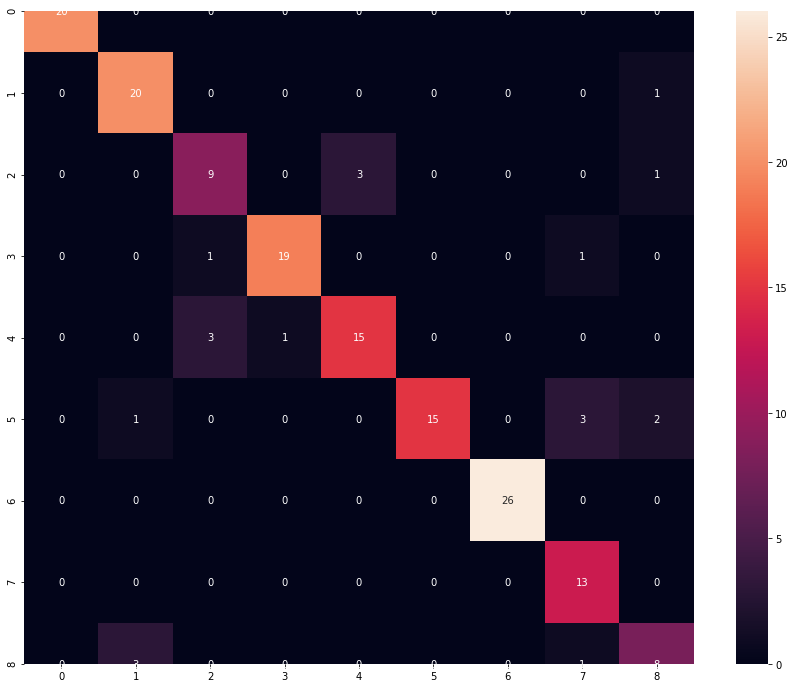

In [24]:
plt.figure(figsize = (15, 12))
sn.heatmap(confusion_matrix, annot=True)

The lines below can be used to save the model weights and state_dict and also retrieve the model

In [35]:
torch.save(nn_model.state_dict(), "NN_9moves_WY_85.pt")

In [8]:
nn_model = neural_network_model_fpga(input_size=in_size, hidden_states= [256,128], output_size=out_size)
nn_model.load_state_dict(torch.load("NN_3moves_3posnew_90_best.pt"))
nn_model.eval()

Sequential(
  (0): QuantStub()
  (1): Linear(in_features=86, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=6, bias=True)
  (6): LogSoftmax()
  (7): DeQuantStub()
)

## Extra Trees Classifier

In [5]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import make_classification

In [12]:
clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

ExtraTreesClassifier(random_state=0)

In [14]:
ExtraTreesClassifier(random_state=0)
res = clf.predict(X)
cor = 0
total = len(res)
for i in range(total):
    if res[i] == y[i]:
        cor += 1
print('Accuracy of Extra trees on Test set- ', cor/total)

Accuracy of Extra trees on Test set-  0.8730350665054414


## ML Model for position detection

Run below when new data is added

In [2]:
pre_process_position_data('C:\\Users\\shrey\\Desktop\\NUS- Everything\\Semester 7\\CG4002\\CG4002_B18\\DataSets\\position\\Shre_5_11')

In [5]:
dataset = 'C:\\Users\\shrey\\Desktop\\NUS- Everything\\Semester 7\\CG4002\\CG4002_B18\\DataSets\\'
combine_all_position_data(dataset)

In [15]:
dataset_position = 'C:\\Users\\shrey\\Desktop\\NUS- Everything\\Semester 7\\CG4002\\CG4002_B18\\DataSets\\position\\Shre_5_11\\'

sampling_rate_position = 5
window_size_position = 2.56

X_position, y_position = load_position_data_w11(dataset_position, sampling_rate_position, window_size_position)

X_position, y_position = shuffle(X_position, y_position)
X_position_train, X_position_test = X_position[:int(len(X_position)*0.8), :], X_position[int(len(X_position)*0.8):, :]
y_position_train, y_position_test = y_position[:int(len(X_position)*0.8), :], y_position[int(len(X_position)*0.8):, :]

X_position_train = torch.from_numpy(X_position_train).float()
y_position_train = torch.from_numpy(y_position_train).float()
y_position_train = y_position_train.reshape(y_position_train.shape[0]).long()

X_position_test = torch.from_numpy(X_position_test).float()
y_position_test = torch.from_numpy(y_position_test).float()
y_position_test = y_position_test.reshape(y_position_test.shape[0]).long()

in_size_position = X_position.shape[1]
out_size_position = one_hot_encoder(y_position).shape[1]

position_model = neural_network_model_fpga(input_size=in_size_position, hidden_states= [256,128], output_size=out_size_position)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(position_model.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

trainloader_position, testloader_position = load_neural_network_data(X_position_train, y_position_train, X_position_test, y_position_test)


Files read from left.txt
Files read from none.txt
Files read from right.txt


In [16]:
X_position.shape

(113, 86)

In [17]:
def score_function(engine):
    val_loss = engine.state.metrics['crossentropy']
    accuracy = engine.state.metrics['accuracy']
    return accuracy

trainer = create_supervised_trainer(position_model, optimizer, loss)
evaluator = create_supervised_evaluator(position_model,
                                        metrics={
                                            'accuracy': Accuracy(),
                                            'crossentropy': Loss(loss)
                                            })

handler = EarlyStopping(patience=5, score_function=score_function, trainer=trainer)
# Note: the handler is attached to an *Evaluator* (runs one epoch on validation dataset).
evaluator.add_event_handler(Events.COMPLETED, handler)

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(trainloader_position)
    metrics = evaluator.state.metrics
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, metrics['accuracy'], metrics['crossentropy']))

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(testloader_position)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, metrics['accuracy'], metrics['crossentropy']))

trainer.run(trainloader_position, max_epochs=35)

nb_classes_position = 3

confusion_matrix_position = np.zeros((nb_classes_position, nb_classes_position))
correct_position = total_position = 0

with torch.no_grad():
    for inputs, labels in testloader_position:
        outputs = position_model(inputs)
        
        _, predicted = torch.max(outputs, 1)
        total_position += labels.size(0)
        correct_position += (predicted == labels).sum().item()
        for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix_position[t.long(), p.long()] += 1

print('Accuracy of the network on the test inputs: %d %%' % (
    100 * correct_position / total_position))
print('Confusion Matrix of position detection- ')
print(confusion_matrix_position)

Training Results - Epoch: 1  Avg accuracy: 0.62 Avg loss: 2.59
Validation Results - Epoch: 1  Avg accuracy: 0.70 Avg loss: 1.36
Training Results - Epoch: 2  Avg accuracy: 0.77 Avg loss: 0.65
Validation Results - Epoch: 2  Avg accuracy: 0.83 Avg loss: 0.65
Training Results - Epoch: 3  Avg accuracy: 0.90 Avg loss: 0.36
Validation Results - Epoch: 3  Avg accuracy: 0.87 Avg loss: 0.43
Training Results - Epoch: 4  Avg accuracy: 0.86 Avg loss: 0.60
Validation Results - Epoch: 4  Avg accuracy: 0.91 Avg loss: 0.16
Training Results - Epoch: 5  Avg accuracy: 0.82 Avg loss: 0.32
Validation Results - Epoch: 5  Avg accuracy: 0.96 Avg loss: 0.14
Training Results - Epoch: 6  Avg accuracy: 0.87 Avg loss: 0.31
Validation Results - Epoch: 6  Avg accuracy: 0.74 Avg loss: 0.33
Training Results - Epoch: 7  Avg accuracy: 0.90 Avg loss: 0.24
Validation Results - Epoch: 7  Avg accuracy: 0.87 Avg loss: 0.22
Training Results - Epoch: 8  Avg accuracy: 0.96 Avg loss: 0.15
Validation Results - Epoch: 8  Avg accura

In [18]:
torch.save(position_model.state_dict(), "Position_Shre.pt")